#A tutorial on Markowitz portfolio optimization in Python using cvxopt

Authors: Dr. Thomas Starke, David Edwards, Dr. Thomas Wiecki

##About the author:

Today's blog post is written in collaboration with [Dr. Thomas Starke](http://drtomstarke.com/). It is based on a longer whitepaper by Thomas Starke on the relationship between Markowitz portfolio optimization and Kelly optimization. The full whitepaper can be found [here](http://eepurl.com/4Pgrv).

## Introduction
In this blog post you will learn about the basic idea behind Markowitz portfolio optimization as well as how to do it in Python. We will then show how you can create a simple backtest that rebalances its portfolio in a Markowitz-optimal way. We hope you enjoy it and get a little more enlightened in the process. 

In this post we will use random data rather than actual stock data, which will hopefully help you to get a sense of how to use modelling and simulation to improve your understanding of the theoretical concepts. Don‘t forget that the skill of an algo-trader is to put mathematical models into code and this example is great practice.

As a final note we would like to point out that from my experience there are a lot of people with IT experience reading these articles who do not always have the in-depth mathematical background. For that reason I try not to jump
too many steps to increase the educational value. So let‘s start with importing a few modules, which we need later and produce a series of normally distributed returns. `cvxopt` is a convex solver which you can easily download with
`sudo pip install cvxopt`.

## Simulations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [2]:
import plotly
import cufflinks
plotly.__version__

'1.4.7'

In [3]:
# (*) To communicate with Plotly's server, sign in with credentials file
import plotly.plotly as py  

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

Assume that we have 4 assets, each with a return series of length 1000. We can use `numpy.random.randn` to sample returns from a normal distribution.

In [4]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

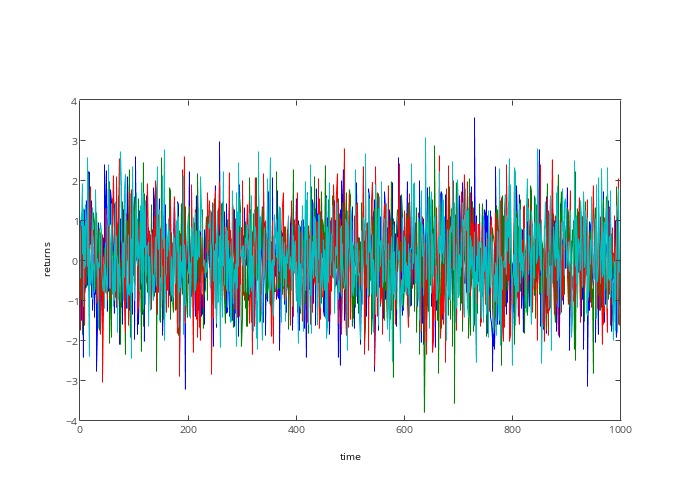

In [5]:
fig = plt.figure()
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
py.iplot_mpl(fig, filename='s6_damped_oscillation')

These return series can be used to create a wide range of portfolios, which all
have different returns and risks (standard deviation). We can produce a wide range
of random weight vectors and plot those portfolios. As we want all our capital to be invested, this vector will have to some to one.

In [6]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


Next, lets evaluate how many of these random portfolios would perform. Towards this goal we are calculating the mean returns as well as the volatility (here we are using standard deviation). You can also see that there is
a filter that only allows to plot portfolios with a standard deviation of < 2 for better illustration.

In [7]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In the code you will notice the calculation of the return with:

$$ R = p^T w $$

where $R$ is the expected return, $p^T$ is the transpose of the vector for the mean
returns for each time series and w is the weight vector of the portfolio. $p$ is a Nx1
column vector, so $p^T$ turns into a 1xN row vector which can be multiplied with the
Nx1 weight (column) vector w to give a scalar result. This is equivalent to the dot
product used in the code. Keep in mind that `Python` has a reversed definition of
rows and columns and the accurate `NumPy` version of the previous equation would
be `R = w * p.T`

Next, we calculate the standard deviation with

$$\sigma = \sqrt{w^T C w}$$

where $C$ is the covariance matrix of the returns which is a NxN matrix. Please
note that if we simply calculated the simple standard deviation with the appropriate weighting using `std(array(ret_vec).T*w)` we would get a slightly different
’bullet’. This is because the simple standard deviation calculation would not take
covariances into account. In the covariance matrix, the values of the diagonal
represent the simple variances of each asset while the off-diagonals are the variances between the assets. By using ordinary `std()` we effectively only regard the
diagonal and miss the rest. A small but significant difference.

Lets generate the mean returns and volatility for 500 random portfolios:

In [8]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

Upon plotting those you will observe that they form a characteristic parabolic
shape called the ‘Markowitz bullet‘ with the boundaries being called the ‘efficient
frontier‘, where we have the lowest variance for a given expected.

/home/wiecki/envs/zipline_p14/local/lib/python2.7/site-packages/plotly/matplotlylib/renderer.py:514: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



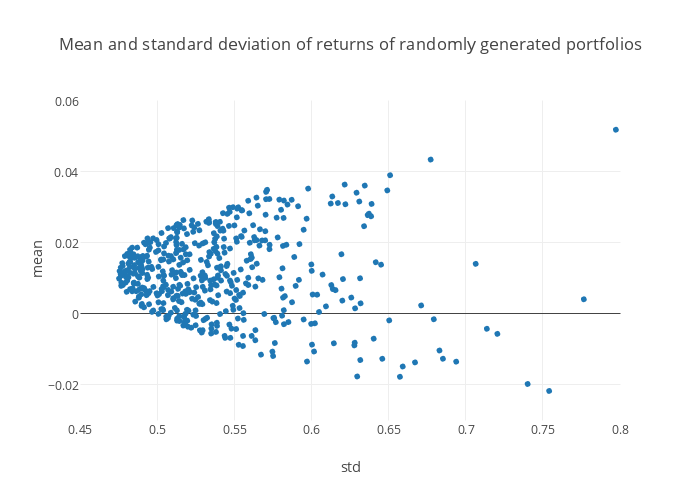

In [9]:
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
py.iplot_mpl(fig, filename='mean_std', strip_style=True)

## Markowitz optimization and the Efficient Frontier

Once we have a good representation of our portfolios as the blue dots show we can calculate the efficient frontier Markowitz-style. This is done by minimising

$$ w^T C w$$

for $w$ on the expected portfolio return $R^T w$ whilst keeping the sum of all the
weights equal to 1:

$$ \sum_{i}{w_i} = 1 $$
Here we parametrically run through $R^T w = \mu$ and find the minimum variance
for different $\mu$‘s. This can be done with `scipy.optimise.minimize` but we have
to define quite a complex problem with bounds, constraints and a Lagrange multiplier. Conveniently, the `cvxopt` package, a convex solver, does all of that for us. We used one of their [examples]() with some modifications as shown below. You will notice that there are some conditioning expressions in the code. They are simply needed to set up the problem. For more information please have a look at the `cvxopt` example.

The `mus` vector produces a series of expected return values $\mu$ in a non-linear and more appropriate way. We will see later that we don‘t need to calculate a lot of these as they perfectly fit a parabola, which can safely be extrapolated for higher values.

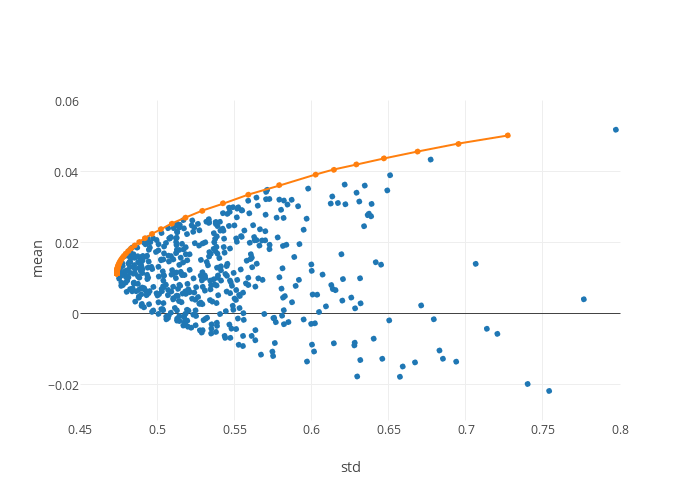

In [10]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
py.iplot_mpl(fig, filename='efficient_frontier', strip_style=True)

In yellow you can see the optimal portfolios for each of the desired returns (i.e. the `mus`). In addition, we get the one optimal portfolio returned:

In [11]:
print weights

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


## Backtesting on real market data
This is all very interesting but not very applied. We next demonstrate how you can create a simple algorithm in [`zipline`](http://github.com/quantopian/zipline) -- the open-source backtester that powers [Quantopian](https://www.quantopian.com) -- to test this optimization on actual historical stock data.

First, lets load in some historical data using [Quantopian](https://www.quantopian.com)'s data (if we are running in the [Quantopian Research Platform](http://blog.quantopian.com/quantopian-research-your-backtesting-data-meets-ipython-notebook/), or the `load_bars_from_yahoo()` function from `zipline`.

In [12]:
from zipline.utils.factory import load_bars_from_yahoo
end = pd.Timestamp.utcnow()
start = end - 2500 * pd.tseries.offsets.BDay()

data = load_bars_from_yahoo(stocks=['IBM', 'GLD', 'XOM', 'AAPL', 
                                    'MSFT', 'TLT', 'SHY'],
                            start=start, end=end)

IBM
GLD
XOM
AAPL
MSFT
TLT
SHY


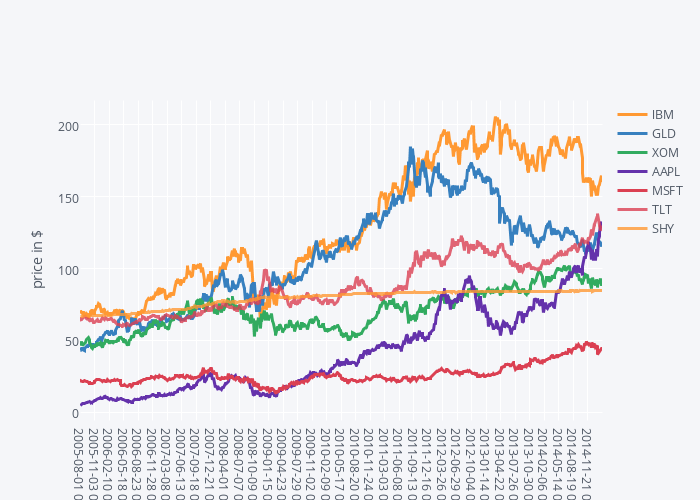

In [13]:
data.loc[:, :, 'price'].iplot(filename='prices', yTitle='price in $', world_readable=True)

Next, we'll create a `zipline` algorithm by defining two functions -- `initialize()` which is called once before the simulation starts, and `handle_data()` which is called for every trading bar. We then instantiate the algorithm object.

If you are confused about the syntax of `zipline`, check out the [tutorial](http://nbviewer.ipython.org/github/quantopian/zipline/blob/master/docs/tutorial.ipynb).

[2015-03-02 09:52] INFO: Performance: Simulated 2411 trading days out of 2411.
[2015-03-02 09:52] INFO: Performance: first open: 2005-08-01 13:31:00+00:00
[2015-03-02 09:52] INFO: Performance: last close: 2015-02-27 21:00:00+00:00


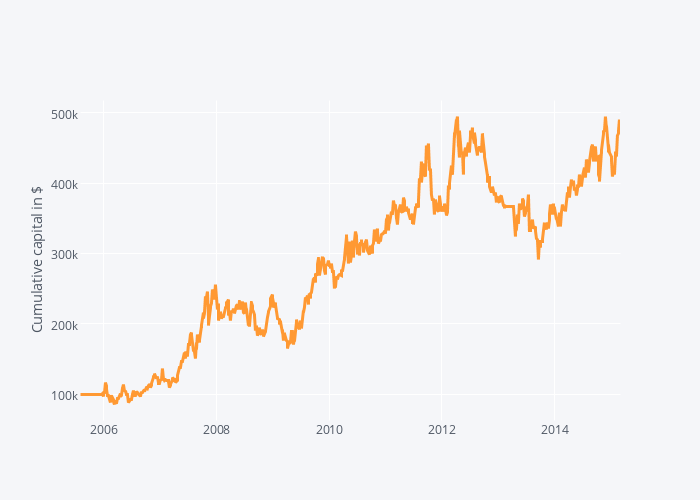

In [14]:
import zipline
from zipline.api import (add_history, 
                         history, 
                         set_slippage, 
                         slippage,
                         set_commission, 
                         commission, 
                         order_target_percent)

from zipline import TradingAlgorithm


def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    # Register history container to keep a window of the last 100 prices.
    add_history(100, '1d', 'price')
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    prices = history(100, '1d', 'price').dropna()
    returns = prices.pct_change().dropna()
    try:
        # Perform Markowitz-style portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)
# Run algorithm
results = algo.run(data)
results.portfolio_value.iplot(filename='algo_perf', yTitle='Cumulative capital in $', world_readable=True)

As you can see, the performance here is pretty good, even through the 2008 financial crisis. This is most likey due to our universe selection and shouldn't always be expected. Increasing the number of stocks in the universe might reduce the volatility as well. Please let us know in the comments section if you had any success with this strategy and how many stocks you used.

## Conclusions

In this blog post, co-written by Quantopian friend [Dr. Thomas Starke](http://drtomstarke.com/), we wanted to provide an intuitive and gentle introduction to Markowitz portfolio optimization which still remains relevant today. By using simulation of various random portfolios we have seen that certain portfolios perform better than others. Convex optimization using `cvxopt` allowed us to then numerical determine the portfolios that live on the *efficient frontier*. The zipline backtest serves as an example but also shows compelling performance.

## Next steps

* Clone this notebook in the [Quantopian Research Platform](http://blog.quantopian.com/quantopian-research-your-backtesting-data-meets-ipython-notebook/) and run it on your own to see if you can enhance the performance. See [here]() for a forum thread containing this Notebook on Quantopian.
* You can also download just the notebook for use in your own environment [here](https://raw.githubusercontent.com/quantopian/research_public/master/Markowitz-blog.ipynb).
* Read a recent interview with Harry Markowitz: [What Does Harry Markowitz Think?](www.brunodefinetti.it/Spigolature/whatdoesharrymarkowitzthink.pdf)
* In a future blog post we will outline the connections to Kelly optimization which also tells us the amount of leverage to use.
* We are currently in the process of adding `cvxopt` to the Quantopian backtester -- stay tuned!